## Shortest path planning

example from motion planning course offered by Univ of Toronto

A map of Berkley, California is given
* Implement Dijkstra's search algorithm on a road network graph.
* Implement the A* search algorithm using a Euclidean heuristic on a road network graph. 

[OSMNX library](https://osmnx.readthedocs.io/en/stable/) is used to generate Python graphs from Open Street Map (OSM) data. You can install OSMNX through `conda` [here](https://anaconda.org/conda-forge/osmnx)

In [1]:
import osmnx as ox
import networkx as nx
import numpy as np
from sklearn.neighbors import KDTree

In [2]:
#from https://github.com/sidmitra/osmnx_playground

dist = 1609.34 * 2 # radius in meters (approx 2 miles)
places = [
    ['delhi', (28.632821, 77.219459)], 
    ['mumbai', (18.932018, 72.834971)], 
    ['kolkatta', (22.566929, 88.347260)], 
    ['chennai', (13.080271, 80.284657)], 
    ['bengaluru', (12.977830, 77.593817)], 
    ['hyderabad', (17.366103, 78.469492)], 
    ['ahmedabad', (23.026948, 72.574903)], 
    ['jaipur', (26.907290, 75.805467)], 
    ['chandigarh', (30.732453, 76.772294)],
    ['pune', (18.519708, 73.856646)],
    ['lucknow', (26.845984, 80.946011)],
    ['gandhinagar', (23.224847, 72.646416)],   
]

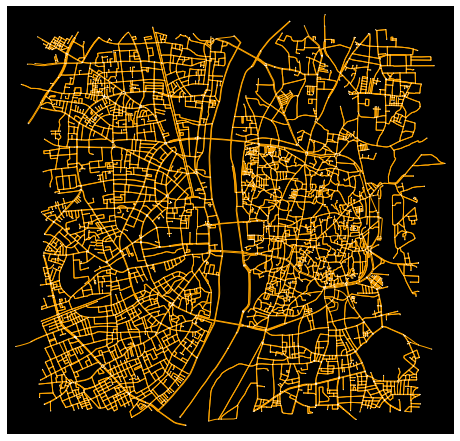

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [3]:
name, point = places[6]
nt = 'drive_service'
G = ox.graph_from_point(point, dist=dist,dist_type="bbox", network_type=nt, 
                        truncate_by_edge=True)
ox.plot_graph(G, node_size=1, edge_color='orange', bgcolor='#000000', show=True)

Print the edges and nodes of this graph

In [4]:
print(f"{G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

5307 nodes and 13018 edges


Arbitrarily select the first node and last node in the Graph and find the shortest path

In [5]:
list(G.nodes())[0]

245711252

In [6]:
origin = list(G.nodes())[0]
destination = list(G.nodes())[1000]
shortest_path = nx.shortest_path(G, origin, destination)

Now visualize using plot_graph_route

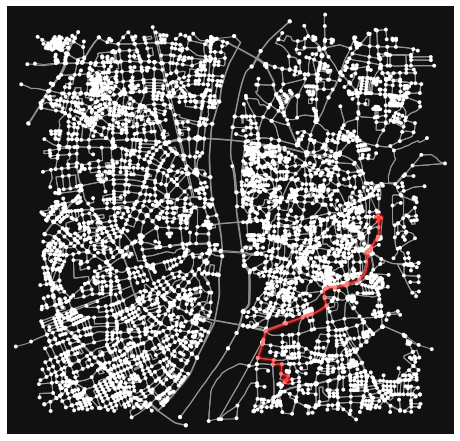

In [7]:
fig, ax = ox.plot_graph_route(G, shortest_path)

In [8]:
# Problem adapted from Introduction to AI, U of Toronto
# https://github.com/booklover98/A-star-Pathfinding

oshawa = (43.945403, -78.892466)
G = ox.graph_from_point(oshawa, dist=2000)
start = ox.geocode('2000 Simcoe St N, Oshawa, Ontario')
end = ox.geocode('18 Niagara Dr, Oshawa, Ontario')

#Convert the graph into geopandas dataframe
# easy to query closest node etc
nodes, _ = ox.graph_to_gdfs(G)
nodes.head()

,y,x,street_count,highway,geometry
osmid,,,,,
278589216,43.928847,-78.874744,3,NaN,POINT (-78.87474 43.92885)
278589217,43.928758,-78.874863,3,NaN,POINT (-78.87486 43.92876)
278589220,43.928360,-78.877049,3,NaN,POINT (-78.87705 43.92836)
278589616,43.950166,-78.885872,3,NaN,POINT (-78.88587 43.95017)
278589617,43.949039,-78.885790,3,NaN,POINT (-78.88579 43.94904)


In [9]:
print(f"Have to go from {start} to {end}")

Have to go from (43.94833105, -78.89816678087453) to (43.94056477087805, -78.88658445298086)


Query the path from start to end. The `start` and `end` values may not be in the `nodes` geopandas dataframe. Query them using a [KDTree](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KDTree.html#sklearn-neighbors-kdtree) (find nearest nodes) and use them as `origin` and `destination` nodes. Then, run the Dijkstra search algorithm.

In [10]:
# Convert to KDTree (for efficient search)
#   https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KDTree.html#sklearn.neighbors.KDTree.query
nodes_yx = np.array(list(zip(nodes["y"], nodes["x"])))
tree = KDTree(nodes_yx)
# Query and get the indices of the nearest nodes (nearest start and end)
queries = [list(start), list(end)]
distances, indices = tree.query(queries)
start_index, end_index = indices[:, 0]
# Get the closest nodes in the database
#   https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.iloc.html#pandas.DataFrame.iloc
closest_start_node = nodes.iloc[start_index]
closest_end_node = nodes.iloc[end_index]
# retrieve origin and destination node id (Name of the dataframe)
origin = closest_start_node.name
destination = closest_end_node.name

# shortest path between source and destination
shortest_path = nx.shortest_path(G, origin, destination)

Visualize the shortest path and graph

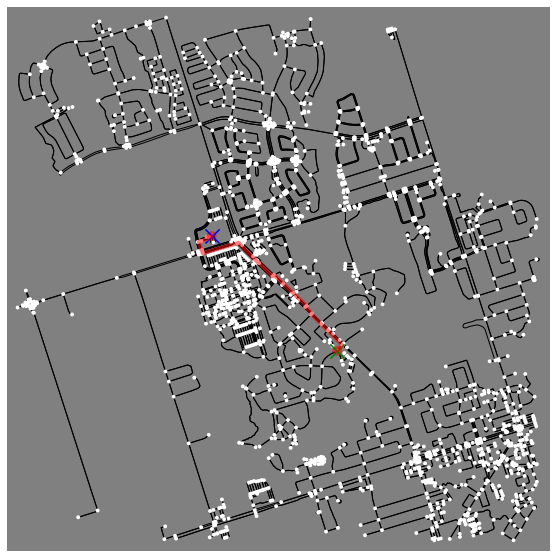

In [11]:
#plot graph with geocodes and nodes
fig, ax = ox.plot_graph_route(G, shortest_path, figsize=(10,10), edge_color='black',
                  show=False, close=False, route_color='red', bgcolor='gray')
ax.scatter(closest_start_node['x'], closest_start_node['y'], marker='x', c='blue', s=200)
ax.scatter(closest_end_node['x'], closest_end_node['y'], marker='x', c='green', s=200)

## Navigation in an Indian city

Use these ideas to find shortest path between 2 addresses/ geocodes in an Indian city of your choice. Using Bangalore here. Using the A* algorithm instead of Dijkstra.

In [12]:
# Get the Bangalore road map
name, coords = places[4]
nt='drive_service'
dist = 1609.34 * 10 # radius in meters (10 miles ~ 16 Kms)
G = ox.graph_from_point(coords, dist, network_type=nt, truncate_by_edge=True)

Show the map

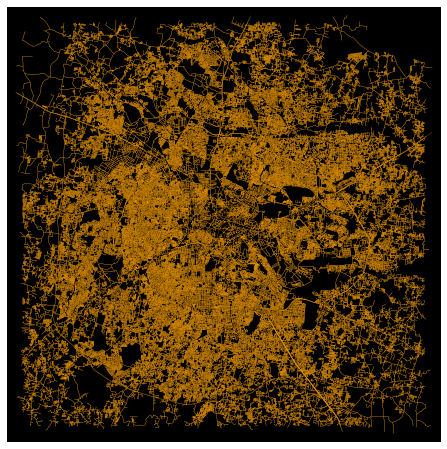

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [13]:
ox.plot_graph(G, node_size=0, edge_color='orange', bgcolor='#000000', show=True, 
              edge_linewidth=0.2)

In [14]:
# Convert graph to Geopandas dataframe (for query resolution)
nodes, _ = ox.graph_to_gdfs(G)
print(nodes.head())
# Get the KDTree
nodes_yx = np.array(list(zip(nodes["y"], nodes["x"])))
tree = KDTree(nodes_yx)

                  y          x  street_count          highway  \
osmid                                                           
17327095  12.910542  77.598721             4              NaN   
17327106  12.917159  77.585832             4  traffic_signals   
17327139  12.934971  77.624083             3              NaN   
17327141  12.938493  77.629168             3              NaN   
17327420  13.095319  77.594113             3              NaN   

                           geometry  
osmid                                
17327095  POINT (77.59872 12.91054)  
17327106  POINT (77.58583 12.91716)  
17327139  POINT (77.62408 12.93497)  
17327141  POINT (77.62917 12.93849)  
17327420  POINT (77.59411 13.09532)  


Go from a start to end

In [15]:
# Start and end addresses (as text)
start_address = "Royal Meenakshi Mall, Bannerghatta Road, Bangalore"
end_address = "IISc, Bangalore"
# Addresses as (Lat, Long) pairs
start = ox.geocode(start_address)
end = ox.geocode(end_address)
# Make a query to the KDTree (for nearest node)
queries = [list(start), list(end)]
distances, indices = tree.query(queries)
start_index, end_index = indices[:, 0]
# Get the closest nodes
closest_start_node = nodes.iloc[start_index]
closest_end_node = nodes.iloc[end_index]
# Get the OSM ID
origin = closest_start_node.name
destination = closest_end_node.name

Get the route from source to destination using A* algorithm (using euclidean metric over Lat/Long)

In [16]:
# Heuristic function
def euclidean(node1, node2):
  x1 = nodes.loc[node1]["x"]  # Long
  y1 = nodes.loc[node1]["y"]  # Lat
  x2 = nodes.loc[node2]["x"]
  y2 = nodes.loc[node2]["y"]
  return ((x2-x1)**2 + (y2-y1)**2)**(0.5)
# Weight
weight = 1.0
# Get the A* path (edge attributes already set from graph)
astar_path = nx.astar_path(G, origin, destination, 
                  heuristic=lambda n1, n2: weight * euclidean(n1, n2))

Show the path on the map

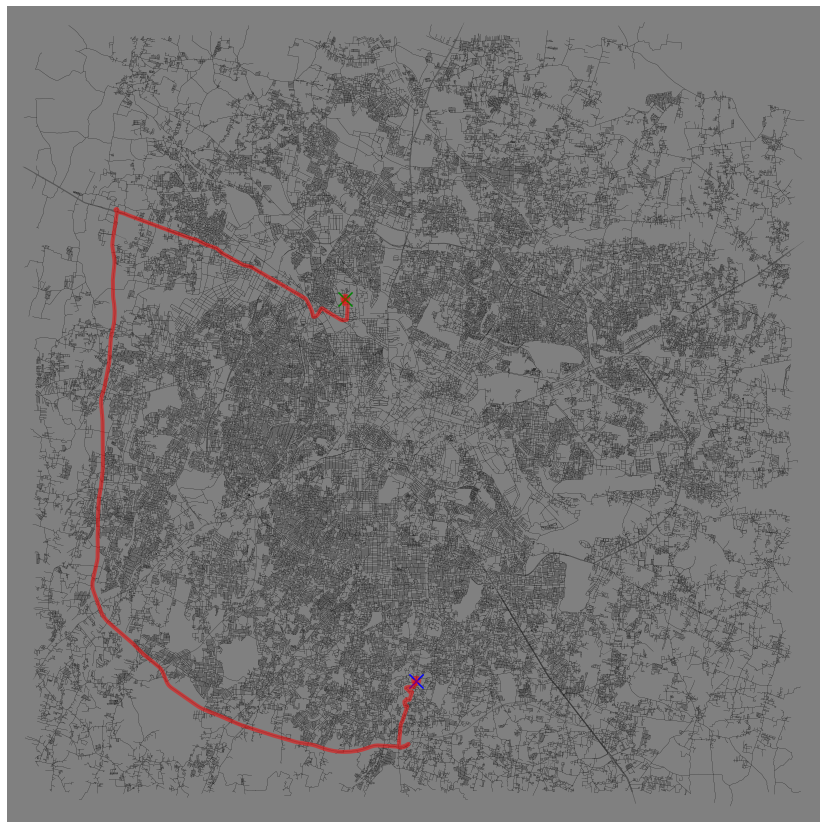

In [17]:
# Show map with path
fig, ax = ox.plot_graph_route(G, astar_path, figsize=(15, 15), 
              edge_color='black', show=False, close=False, route_color='red', 
              bgcolor='gray', node_size=0, edge_linewidth=0.1)
# Show the start and end nodes
ax.scatter(closest_start_node["x"], closest_start_node["y"], marker='x', c='blue', s=200)
ax.scatter(closest_end_node["x"], closest_end_node["y"], marker='x', c='green', s=200)

This seems like the route that Google Maps gives (for direction through nice road, probably the fastest route but takes time and has tolls)

![Google Maps view](https://drive.google.com/uc?export=view&id=1AcqCMjdngJ8Hy1TLRnbm7YQPTg69Q_hX)

Image inserted using help from [this StackOverflow answer](https://stackoverflow.com/a/62337161)